In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import torch
import random
import logging

import matplotlib.pyplot as plt

from os.path import isfile, isdir, join
from datetime import datetime

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/research/LineVulCopy/linevul
%rm cat_linevul.py
%rm cat_linevul_model.py

/content/drive/MyDrive/research/LineVulCopy/linevul
rm: cannot remove 'cat_linevul.py': No such file or directory
rm: cannot remove 'cat_linevul_model.py': No such file or directory


In [5]:
CWD = os.getcwd()

CWD

'/content/drive/MyDrive/research/LineVulCopy/linevul'

In [6]:
os.listdir()

['saved_models',
 'multiclass_data_n_model.ipynb',
 'dataset_gen_utils.py',
 '.ipynb_checkpoints',
 'linevul_main.py',
 'linevul_model.py',
 '__pycache__',
 'code_tester.ipynb']

In [ ]:
from google.colab import files

files.upload()

In [8]:
from cat_linevul_model import Model
from cat_linevul import *

In [9]:
DATA_DIR = "../data/cat"
train_csv_filename = "cat_boost_train.csv"
val_csv_filename = "cat_boost_val.csv"
test_csv_filename = "cat_boost_test.csv"

In [10]:
TRAIN_SRC_PATH = join(DATA_DIR, train_csv_filename)
VAL_SRC_PATH = join(DATA_DIR, val_csv_filename)
TEST_SRC_PATH = join(DATA_DIR, test_csv_filename)

train_df = pd.read_csv(TRAIN_SRC_PATH)
val_df = pd.read_csv(VAL_SRC_PATH)
test_df = pd.read_csv(TEST_SRC_PATH)

In [11]:
train_targets = train_df["target"].tolist()
val_targets = val_df["target"].tolist()
test_targets = test_df["target"].tolist()

train_target_torch = torch.tensor(train_targets)

print(type(train_target_torch))

class_distribution_dict = dict()

unq_train_tgs = set(train_targets)

for tg in unq_train_tgs:
  class_distribution_dict[f"label_{tg}"] = train_targets.count(tg)

<class 'torch.Tensor'>


In [12]:
len(class_distribution_dict)

89

In [13]:
class_count = [i for i in class_distribution_dict.values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float)

class_weights_all = class_weights[train_target_torch]

weighted_smapler = WeightedRandomSampler(weights=class_weights_all, num_samples=len(class_weights_all), replacement=True)

In [14]:
EPOCHS = 1
BATCH_SIZE = 16
LEARNING_RATE = 5e-5
NUM_FEATURES = 1
NUM_CLASSES = len(class_distribution_dict)

In [15]:
NUM_CLASSES

89

In [16]:
args = {
  "tokenizer_name": "microsoft/codebert-base",
  "model_name_or_path": "microsoft/codebert-base",
  "model_name": "12heads_linevul_model.bin",
  "output_dir": "./saved_models",
  "use_word_level_tokenizer": False,
  "block_size": 512,
  "seed": 42,
  "n_gpu": 0,
  "num_attention_heads": 12,
  "train_batch_size": BATCH_SIZE,
  "epochs": 1,
  "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
  "weight_decay": 0.0,
  "learning_rate": LEARNING_RATE,
  "adam_epsilon": 1e-8,
  "gradient_accumulation_steps": 1,
  "max_grad_norm": 1
}

In [17]:
set_seed(args)

In [18]:
tokenizer = RobertaTokenizer.from_pretrained(args["tokenizer_name"])

train_dataset = TextDataset(train_df, train_target_torch, tokenizer, args)

  0%|          | 0/149303 [00:00<?, ?it/s]

In [19]:
val_target_torch = torch.tensor(val_targets)
test_target_torch = torch.tensor(test_targets)

val_dataset = TextDataset(val_df, val_target_torch, tokenizer, args)
test_dataset = TextDataset(test_df, test_target_torch, tokenizer, args)

  0%|          | 0/18768 [00:00<?, ?it/s]

  0%|          | 0/18768 [00:00<?, ?it/s]

In [20]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_smapler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [21]:
config = RobertaConfig.from_pretrained(args["model_name_or_path"])
config.num_labels = NUM_CLASSES
config.num_attention_heads = args["num_attention_heads"]

In [22]:
model = RobertaForSequenceClassification.from_pretrained(args["model_name_or_path"], config=config, ignore_mismatched_sizes=True)

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be 

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model(model, config, tokenizer, args)

In [24]:
logger = logging.getLogger(__name__)

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',datefmt='%m/%d/%Y %H:%M:%S',level=logging.INFO)
logger.warning("device: %s, n_gpu: %s",device, args["n_gpu"],)

In [25]:
now = datetime.now()
curr_timestamp = now.strftime("%m_%d_%Y_%H_%M_%S")

In [1]:
train(args, train_dataset, weighted_smapler, model, tokenizer, val_dataset, curr_timestamp, logger)

NameError: ignored

In [ ]:
df = pd.read_csv(SRC_PATH)
df.head()

FileNotFoundError: ignored

In [ ]:
vul_df = df.query("target != 0")from sklearn.model_selection import train_test_split

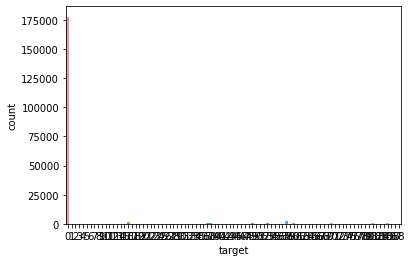

In [ ]:
fig = sns.countplot(x="target", data=df).get_figure()

In [ ]:
fig.savefig("../data/cat/vul_cnt.png")

In [ ]:
X = df.drop("target", axis=1)
Y = df["target"]

type(X)

pandas.core.frame.DataFrame

In [ ]:
def boost_with_dupes(df: pd.DataFrame, dup_cnt=10):
    Y_list = df["target"].tolist()
    
    unq_targets = set(Y_list)

    dupe_targets = []

    for tg in unq_targets:
        cnt = Y_list.count(tg)
        if cnt < 2:
            dupe_targets.append(tg)
    
    X_dupes = []

    for idx, row in df.iterrows():
        if row["target"] in dupe_targets:
            X_dupes.extend([row] * dup_cnt)
    
    new_df = df.append(pd.DataFrame(X_dupes))
    
    return new_df

In [ ]:
# print(len(df.index))
new_df = boost_with_dupes(df)
# print(len(new_df.index))
len(new_df["target"])

/tmp/ipykernel_6268/1242448498.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df.append(pd.DataFrame(X_dupes))


186629

In [ ]:
X_train_df, X_valtest_df, Y_train, Y_valtest = train_test_split(new_df, new_df["target"], test_size=0.2, stratify=new_df["target"])

In [ ]:
type(X_train_df), type(X_valtest_df), type(Y_train), type(Y_valtest)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [ ]:
print(len(X_valtest_df.index))
new_X_valtest_df = boost_with_dupes(X_valtest_df)
len(new_X_valtest_df["target"])

37326


/tmp/ipykernel_6268/1242448498.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = df.append(pd.DataFrame(X_dupes))


37536

In [ ]:
X_val_df, X_test_df, Y_val, Y_test = train_test_split(new_X_valtest_df, new_X_valtest_df["target"], test_size=0.5, stratify=new_X_valtest_df["target"])

In [ ]:
X_train_len = len(X_train_df.index)
Y_train_len = len(Y_train)

X_val_len = len(X_val_df.index)
Y_val_len = len(Y_val)

X_test_len = len(X_test_df.index)
Y_test_len = len(Y_test)

print(X_train_len, Y_train_len)
print(X_val_len, Y_val_len)
print(X_test_len, Y_test_len)

print((X_train_len + X_val_len + X_test_len), (Y_train_len + Y_val_len + Y_test_len))
print(len(df.index))

149303 149303
18768 18768
18768 18768
186839 186839
186519


In [ ]:
DST_DIR = "../data/cat"

filename_df_dict = {
    "train": {
        "filename": "cat_boost_train.csv",
        "dataframe": X_train_df
    },
    "val": {
        "filename": "cat_boost_val.csv",
        "dataframe": X_val_df
    },
    "test": {
        "filename": "cat_boost_test.csv",
        "dataframe": X_test_df
    }
}

for key in filename_df_dict:
    DST_PATH = join(DST_DIR, filename_df_dict[key]["filename"])
    
    if not isfile(DST_PATH):
        with open(DST_PATH, "w"):
            pass
    
    filename_df_dict[key]["dataframe"].to_csv(DST_PATH, index=False)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

ValueError: could not convert string to float: 'void DaemonProcess::CloseDesktopSession(int terminal_id) {\n  DCHECK(caller_task_runner()->BelongsToCurrentThread());\n\n  if (!IsTerminalIdKnown(terminal_id)) {\n    LOG(ERROR) << "An invalid terminal ID. terminal_id=" << terminal_id;\n    RestartNetworkProcess();\n    DeleteAllDesktopSessions();\n    return;\n  }\n\n  DesktopSessionList::iterator i;\n  for (i = desktop_sessions_.begin(); i != desktop_sessions_.end(); ++i) {\n    if ((*i)->id() == terminal_id) {\n      break;\n    }\n  }\n\n  if (i == desktop_sessions_.end())\n    return;\n\n  delete *i;\n  desktop_sessions_.erase(i);\n\n  VLOG(1) << "Daemon: closed desktop session " << terminal_id;\n  SendToNetwork(\n      new ChromotingDaemonNetworkMsg_TerminalDisconnected(terminal_id));\n}\n'

In [ ]:
Y_list = Y.tolist()
unq_targets = set(Y_list)

dupe_targets = []

for tg in unq_targets:
    cnt = Y_list.count(tg)
    
    if cnt < 2:
        dupe_targets.append(tg)

In [ ]:
print(type(X))

X_dupes = []
Y_dupes = []

dup_cnt = 10

for idx, entry in enumerate(X):
    if Y[idx] in dupe_targets:
        X_dupes.extend([entry] * dup_cnt)
        Y_dupes.extend([Y[idx]] * dup_cnt)

<class 'pandas.core.series.Series'>


In [ ]:
print(len(X), len(Y))

X = X.append(pd.Series(X_dupes))
Y = Y.append(pd.Series(Y_dupes))

print(len(X), len(Y))

186519 186519
186629 186629


/tmp/ipykernel_6268/1448872349.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X = X.append(pd.Series(X_dupes))
/tmp/ipykernel_6268/1448872349.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Y = Y.append(pd.Series(Y_dupes))


In [ ]:
X_train, X_valtest, Y_train, Y_valtest = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [ ]:
Y_valtest_list = Y_valtest.tolist()
valtest_unq_targets = set(Y_valtest_list)

valtest_dupe_targets = []

for tg in valtest_unq_targets:
    cnt = Y_valtest_list.count(tg)
    
    if cnt < 2:
        valtest_dupe_targets.append(tg)
        print(cnt, tg)

1 12
1 13
1 19
1 23
1 27
1 28
1 29
1 34
1 35
1 40
1 43
1 55
1 63
1 64
1 68
1 69
1 73
1 80
1 83
1 86
1 88


In [ ]:
X_valtest_dupes = []
Y_valtest_dupes = []

dup_cnt = 10

for idx, entry in enumerate(X_valtest):
    if Y_valtest[idx] in valtest_dupe_targets:
        X_dupes.extend([entry] * dup_cnt)
        Y_dupes.extend([Y[idx]] * dup_cnt)

print(len(X), len(Y))

X = X.append(pd.Series(X_dupes))
Y = Y.append(pd.Series(Y_dupes))

print(len(X), len(Y))

In [ ]:
X_val, X_test, Y_val, Y_test = train_test_split(X_valtest, Y_valtest, test_size=0.5, stratify=Y_valtest)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 label):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.label=label
        

class TextDataset(Dataset):
    def __init__(self, X, Y, tokenizer, args):
        self.examples = []
        funcs = X["processed_func"].tolist()
        labels = Y
        for i in tqdm(range(len(funcs))):
            self.examples.append(convert_examples_to_features(funcs[i], labels[i], tokenizer, args))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):       
        return torch.tensor(self.examples[i].input_ids),torch.tensor(self.examples[i].label)


def convert_examples_to_features(func, label, tokenizer, args):
    if args["use_word_level_tokenizer"]:
        encoded = tokenizer.encode(func)
        encoded = encoded.ids
        if len(encoded) > 510:
            encoded = encoded[:510]
        encoded.insert(0, 0)
        encoded.append(2)
        if len(encoded) < 512:
            padding = 512 - len(encoded)
            for _ in range(padding):
                encoded.append(1)
        source_ids = encoded
        source_tokens = []
        return InputFeatures(source_tokens, source_ids, label)
    # source
    code_tokens = tokenizer.tokenize(str(func))[:args["block_size"]-2]
    source_tokens = [tokenizer.cls_token] + code_tokens + [tokenizer.sep_token]
    source_ids = tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = args["block_size"] - len(source_ids)
    source_ids += [tokenizer.pad_token_id] * padding_length
    return InputFeatures(source_tokens, source_ids, label)

def set_seed(args):
    random.seed(args["seed"])
    np.random.seed(args["seed"])
    torch.manual_seed(args["seed"])
    if args["n_gpu"] > 0:
        torch.cuda.manual_seed_all(args["seed"])